# TreeSHAP-IQ for Custom Tree Models

This tutorial demonstrates how to use the `TreeExplainer` class of `shapiq` to explain any custom tree model.

Here, we will create a tree model from scratch with three simple decision rules and the well-known **Play Tennis** dataset.
Then we will use the `TreeExplainer` class to explain the model's predictions.

### Import Modules

In [1]:
import numpy as np

import shapiq

{"shapiq": shapiq.__version__}

{'shapiq': '1.2.3'}

### The Play Tennis Dataset

We will be using the **Play Tennis** dataset, which has the following features:
- Outlook: Sunny / Overcast / Rainy
- Temperature: Hot / Mild / Cool
- Humidity: High / Normal
- Wind: Weak / Strong
- Play Tennis: Yes / No

The data looks as follows:

| Day | Outlook  | Temperature | Humidity | Wind   | Play Tennis |
|-----|----------|-------------|----------|--------|-------------|
| 1   | Sunny    | Hot         | High     | Weak   | No          |
| 2   | Sunny    | Hot         | High     | Strong | No          |
| 3   | Overcast | Hot         | High     | Weak   | Yes         |
| 4   | Rainy    | Mild        | High     | Weak   | Yes         |
| 5   | Rainy    | Cool        | Normal   | Weak   | Yes         |
| 6   | Rainy    | Cool        | Normal   | Strong | No          |
| 7   | Overcast | Cool        | Normal   | Strong | Yes         |
| 8   | Sunny    | Mild        | High     | Weak   | No          |
| 9   | Sunny    | Cool        | Normal   | Weak   | Yes         |
| 10  | Rainy    | Mild        | Normal   | Weak   | Yes         |
| 11  | Sunny    | Mild        | Normal   | Strong | Yes         |
| 12  | Overcast | Mild        | High     | Strong | Yes         |
| 13  | Overcast | Hot         | Normal   | Weak   | Yes         |
| 14  | Rainy    | Mild        | High     | Strong | No          |

As usual for most tree models features need to be numerical. We will encode the features as follows:
- Outlook: Sunny (1), Overcast (2), Rainy (3)
- Temperature: Hot (1), Mild (2), Cool (3)
- Humidity: High (1), Normal (2)
- Wind: Weak (1), Strong (2)
- Play Tennis: Yes (1), No (0)

In [2]:
# create the dataset
X = np.array(
    [
        [1, 1, 1, 1],
        [1, 1, 1, 2],
        [2, 1, 1, 1],
        [3, 2, 1, 1],
        [3, 3, 2, 1],
        [3, 3, 2, 2],
        [2, 3, 2, 2],
        [1, 2, 1, 1],
        [1, 3, 2, 1],
        [3, 2, 2, 1],
        [1, 2, 2, 2],
        [2, 2, 1, 2],
        [2, 1, 2, 1],
        [3, 2, 1, 2],
    ],
)
y = np.array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])


### Define a Custom Tree Model
We will define a custom tree model with three simple decision rules (note the tree will not predict the same as the original dataset):

1. If Outlook is rainy then don't play tennis.
2. If Outlook is not rainy, and Humidity is high then don't play tennis.
3. If Outlook is not rainy, Humidity is normal, and Wind is strong then don't play tennis.
    
```python
if Outlook == 3:
    return 0
else:
    if Humidity == 1:
        return 0
    else:
        if Wind == 2:
            return 0
        else:
            return 1
```
   
This can be drawn by the following tree structure:
    
    ```
        #0: Outlook
        /         \       
       #1: 0      #2: Humidity
                  /           \
                 #3: 0        #4: Wind
                             /        \
                            #5: 0     #6: 1
    ```
    
To model this tree, we will need to create a custom tree model. We can define a custom model by creating a `shapiq.TreeModel`.
Both the TreeModel object or the dictionary should have the following keys:
- `children_left`: The left child of each node. For leaf nodes, this should be -1.
- `children_right`: The right child of each node. For leaf nodes, this should be -1.
- `features`: The feature id used for splitting at each node. For leaf nodes, this should be -2.
- `thresholds`: The threshold value used for splitting at each node. For leaf nodes, this should be -2.
- `values`: The output value at each leaf node.
- `node_sample_weight`: The sample weight at each node.

In total our tree will have 7 nodes (3 decision nodes and 4 leaf nodes).
The first node (node 0) is always the root node. 
So the left child of the root node is node 1 and the right child is node 2.
Node 1 is already a leaf node, predicting 0.
Node 2 again is a decision node with children 3 and 4.

In [3]:
# define the custom tree model

# this is how the nodes are arranged in the tree
nodes = [0, 1, 2, 3, 4, 5, 6]

tree = {
    "children_left": np.array([1, -1, 3, -1, 5, -1, -1]),
    "children_right": np.array([2, -1, 4, -1, 6, -1, -1]),
    "features": np.array([0, -2, 2, -2, 3, -2, -2]),
    "thresholds": np.array([2.5, -2, 1.5, -2, 1.5, -2, -2]),
    "values": np.array([0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0]),
    "node_sample_weight": np.array([14, 5, 9, 5, 4, 1, 3]),
}
tree = shapiq.explainer.tree.TreeModel(**tree)

In [4]:
# create tree explainer
explainer = shapiq.TreeExplainer(model=tree, index="SV", max_order=1)
shapley_values = explainer.explain(X[5])
print(shapley_values)

InteractionValues(
    index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
    n_players=4, baseline_value=0.21428571428571427,
    Top 10 interactions:
        (np.int64(2),): 0.40343915343915326
        (np.int64(0),): 0.22982804232804224
        (): 0.21428571428571427
        (np.int64(3),): 0.15244708994708991
)


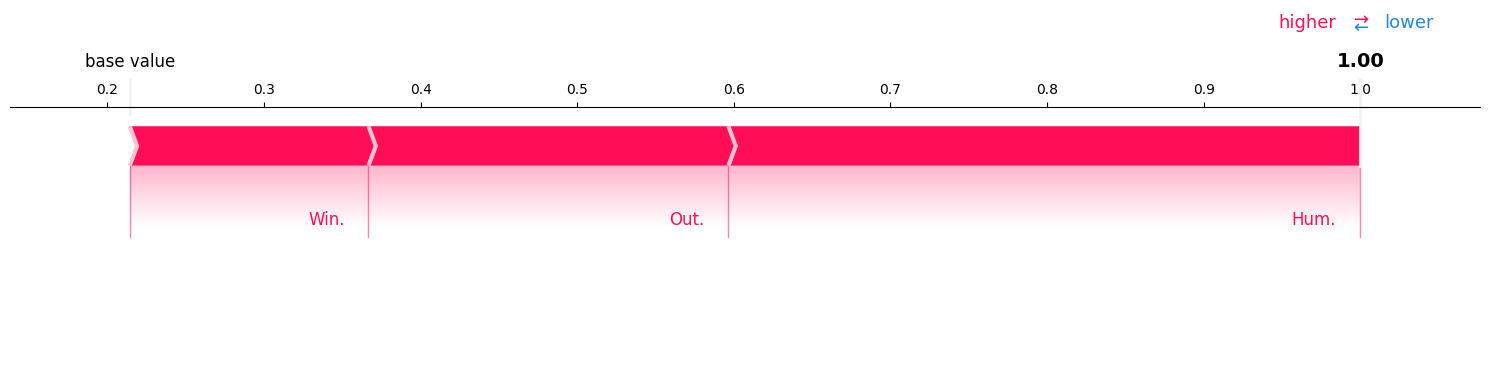

In [5]:
shapley_values.plot_force(feature_names=["Outlook", "Temperature", "Humidity", "Wind"])